## Import Statements 

In [1]:
import os,sys
sys.path.append(os.path.abspath('..'))
from octcv.arrViz import *

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv3D,Conv2D,Dense,MaxPool2D,MaxPool3D,Flatten,Dropout,\
BatchNormalization,GlobalAveragePooling3D,GlobalAveragePooling2D,ReLU,Input
from keras.metrics import AUC
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping

## Loading Modeling/Pre-processed Datasets 

In [3]:
c_test = pd.read_csv('./combined_slices_TEST.csv')
c_train = pd.read_csv('./combined_slices_train.csv')

v_test = pd.read_csv('./volumes_TEST.csv')
v_train = pd.read_csv('./volumes_train.csv')

c_test.shape, c_train.shape, v_test.shape, v_train.shape

((232, 8), (926, 8), (222, 8), (888, 8))

For the case of a unimodal CNN, the entirety of X will be the image data - however, to conserve RAM, will keep as filepaths for now and define a custom function to load the arrays for a given set during training.

In [29]:
yX_split = lambda df : (df.glaucoma.values, df.normalized_array.values)
vy_test,vX_test_paths = yX_split(v_test)
vy_train,vX_train_paths = yX_split(v_train)
print(f"\n3D Volumes - train_test shapes:")
print(f"\tTrain Set(y,X): {vy_test.shape,vX_test_paths.shape}")
print(f"\tTest Set(y,X): {vy_train.shape,vX_train_paths.shape}")

y_test,X_test_paths = yX_split(c_test)
y_train,X_train_paths = yX_split(c_train)
print(f"\nCombined 2D Images - train_test shapes:")
print(f"\tTrain Set(y,X): {y_test.shape,X_test_paths.shape}")
print(f"\tTest Set(y,X): {y_train.shape,X_train_paths.shape}\n")


3D Volumes - train_test shapes:
	Train Set(y,X): ((222,), (222,))
	Test Set(y,X): ((888,), (888,))

Combined 2D Images - train_test shapes:
	Train Set(y,X): ((232,), (232,))
	Test Set(y,X): ((926,), (926,))



In [30]:
def load_images(image_paths):
    if type(image_paths)==pd.DataFrame:
        xarrs = image_paths.normalized_array.apply(vizInputParser).values # shape: (N, 64, 128, 64)
    elif type(image_paths)==np.ndarray or type(image_paths)==list:
        xarrs = np.array([vizInputParser(path) for path in image_paths]) # shape: (N, 64, 128, 64)
    # X = xarrs[...,np.newaxis] # add channel dim → (N, 64, 128, 64, 1)
    return X

## Replicating Prior Model

As discussed previously, the initial step will be an attempt to replicate the results found in the [publication](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0219126) pertaining to SET 1.  Their model as described in the paper:

>"The network is composed of five 3D-convolutional layers with ReLU activation, batch-normalization, filter banks of sizes 32-32-32-32-32, filters of sizes 7-5-3-3-3 and strides 2-1-1-1-1.  After the last convolutional layer Global Average Pooling (GAP) is employed and a dense layer to the final softmax output layer is added to enable the prediction of class labels and the computation of CAMs."

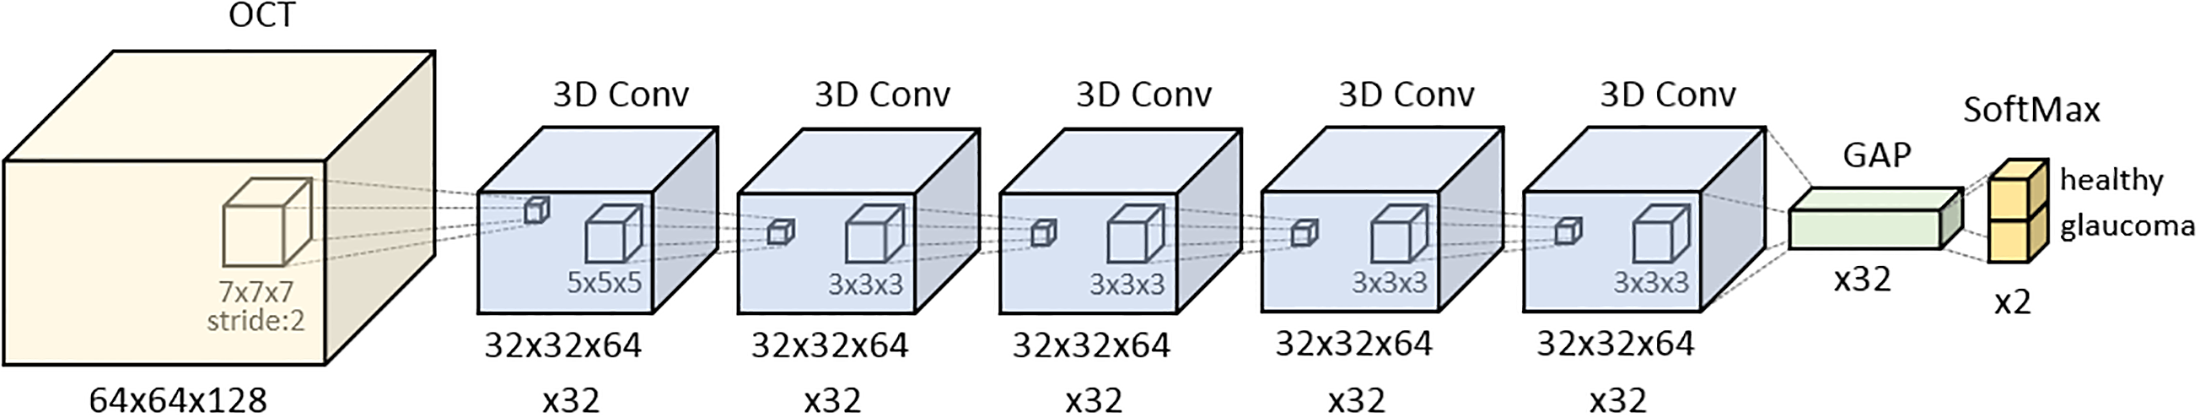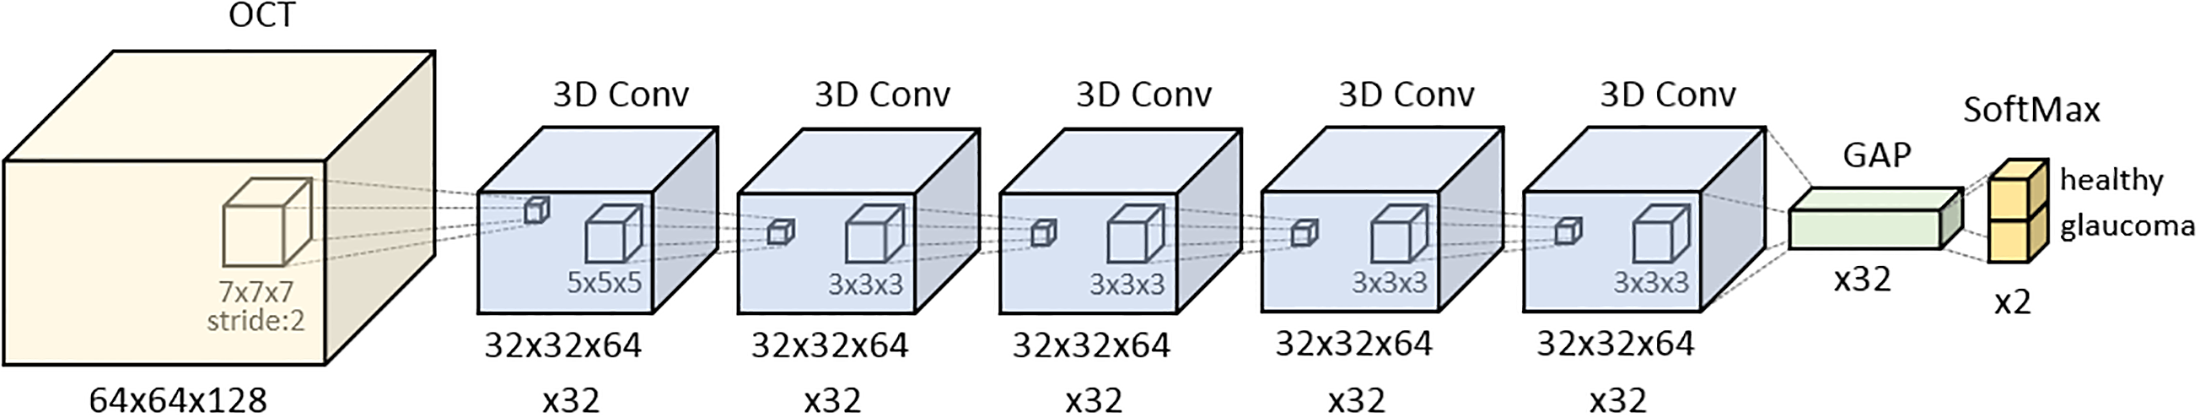

In [31]:
model = Sequential([

    Input(shape=(64, 128, 64, 1)),
    # Layer 1
    Conv3D(32, kernel_size=7, strides=2, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Layer 2
    Conv3D(32, kernel_size=5, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Layer 3
    Conv3D(32, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Layer 4
    Conv3D(32, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Layer 5
    Conv3D(32, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Global Average Pooling
    GlobalAveragePooling3D(),

    # Dense → Softmax (for multi-class CAM support)
    Dense(2, activation='softmax')  # use 1 + sigmoid if binary
])

early_stop = EarlyStopping(
    monitor='val_auc',
    patience=3,
    restore_best_weights=True
)

model.compile(
    optimizer=Nadam(learning_rate=1e-4),
    metrics=['accuracy',AUC(name='auc')],
    loss='binary_crossentropy'
)

# Load volumes for 3D CNN training and run fit
history = model.fit(
    load_images(vX_train_paths),vy_train, 
    validation_data=(load_images(vX_test_paths),vy_test), 
    epochs=100,
    batch_size=8,
    callbacks=[early_stop]
)

NameError: name 'X' is not defined

In [ ]:
# Plot score progression
plt.plot(history.history['val_auc'], label='val AUC', marker='.')
plt.plot(history.history['auc'], label='train AUC', marker='.')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.axvline(saved_epoch, linestyle='--', c='r', label='Saved Epoch')
plt.text(saved_epoch+.2,.8,f"val:    {auc:.4f}\ntrain:  {history.history['auc'][saved_epoch]:.4f}")
plt.legend()
plt.title('AUC over Epochs')